# N-body Simulations and More - SOLUTIONS

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# NOTE: All units in SI
from scipy.constants import gravitational_constant, au

year = 365.25*24*3600 # seconds

mass_sun = 1.989e30 # kg
mass_earth = 5.972e24 # kg
mass_mars = 6.39e23 # kg
mass_jupiter = 1.898e27 # kg

earth_distance = 1.496e11 # meters
mars_distance = 227.9*1.e9 # meters
jupiter_distance = 778.57*1.e9 # meters

scale_factor = (gravitational_constant*mass_sun*year**2/earth_distance**3)

# Masses and distances in our nicely scaled units
mE = mass_earth/mass_sun
mM = mass_mars/mass_sun
mJ = mass_jupiter/mass_sun

rE = earth_distance / earth_distance
rM = mars_distance / earth_distance
rJ = jupiter_distance / earth_distance

## A Realistic Star System

Let's now simulate a realistic solar system. We'll include the Sun and a few planets, and they will all have mass and interact.

We'll make this entirely general, so it can handle N different objects in 3D. Each object will have six variables associated with it - $(x, y, z, v_x, v_y, v_z)$.

Because of the way `odeint` works, we need to store all of the variables in a single 1D array that we'll call `state`. We'll store them in this order in `state`:
 * positions for object `i`: `6*i` to `6*i+3`
 * velocities for object `i`: `6*i+3` to `6*i+6`

Writing these out every time they're needed would make the code very hard to read and debug. So we'll define some helper functions and a class to help process the data. This is the main point of the notebook - it's not so much about solving the ODEs, it's about being able to process the output.

Let's start by defining our derivatives function.

In [2]:
def distance(pos1, pos2):
    return np.sqrt(np.sum((pos2-pos1)**2, axis=-1))

def deriv(state, t, mass):
    derivatives = 0.*state # make an empty array shaped like state
    for i in range(len(mass)):
        pos1 = state[6*i: 6*i+3]
        acc = 0.
        for j in range(len(mass)):
            if j == i: # Object doesn't interact with itself
                continue

            pos2 = state[6*j: 6*j+3]

            r = distance(pos1, pos2)
            vec = pos2 - pos1
            acc += scale_factor * mass[j] * vec / r ** 3

        # Derivative of position is velocity
        derivatives[6*i: 6*i+3] = state[6*i+3: 6*i+6]
        # Derivative of velocity is acceleration
        derivatives[6*i+3: 6*i+6] = acc

    return derivatives


## Exercise

Set up initial conditions for a solar system with the Sun, the Earth, and Jupiter. Remember that the velocity should be $2 \pi / \sqrt{r}$ in our nicely scaled units. Solve this for 100 years. Then plot the $x, y$ positions of the three objects over time. What is wrong with the solution?

In [3]:
mass = np.array([1., mE, mJ])

In [4]:
times = np.linspace(0, 100, 100000)

ic = np.array([
    0, 0, 0, 0, 0, 0, # xSx, xSy, xSz, vSx, vSy, vSz
    rE, 0, 0, 0, np.sqrt(scale_factor/rE), 0, # xEx, xEy, xEz, vEx, vEy, vEz
    rJ, 0, 0, 0, np.sqrt(scale_factor/rJ), 0, # xJx, xJy, xJz, vJx, vJy, vJz
])

soln = odeint(deriv, ic, times, args=(mass,))

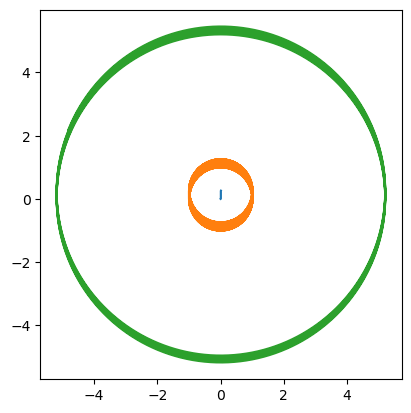

In [5]:
# Make the plot here
fig = plt.figure()
ax = fig.add_subplot(111,)
ax.plot(soln[:,0], soln[:,1], label='Sun')
ax.plot(soln[:,6], soln[:,7], label='Earth')
ax.plot(soln[:,12], soln[:,13], label='Jupiter')
ax.set_aspect('equal')

The solution looks wrong as the objects keep moving away from their circular orbits

## Exercise

The centre of mass is not at rest by default (the total momentum is not zero). Fill in the functions below to calculate position and velocity of each object, then calculate the total momentum

$$p_\mathrm{total} = \sum\limits_{i} ~ m_i \vec{v_i}$$

Divide this by the total mass to get the velocity of the center of mass.

In [6]:
def pos(state, i):
    """The position (3D) of object i"""
    return state[6 * i:6 * i + 3]

def vel(state, i):
    """The velocity (3D) of object i"""
    return state[6 * i + 3:6 * (i + 1)]

def total_momentum(state, mass):
    p_sum = 0.
    for i in range(len(mass)):
        p_sum +=  mass[i] * vel(state, i)
    return p_sum

## Exercise

Now fill in the function to remove the center of mass motion, make and plot the new solution.

In [7]:
def remove_center_of_mass_effects(state, mass):
    new_state = state.copy() # Don't modify the state, create a new one
    
    total_mass = sum(mass)
    # subtract the center of mass velocity from all objects
    v_com = total_momentum(state, mass) / total_mass
    for i in range(len(mass)):
        new_state[6 * i + 3:6 * (i + 1)] -= v_com

    return new_state


In [8]:
new_ic = remove_center_of_mass_effects(ic, mass)
new_ic

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.64481892e-03,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.28121995e+00,  0.00000000e+00,
        5.20434492e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.75186163e+00,  0.00000000e+00])

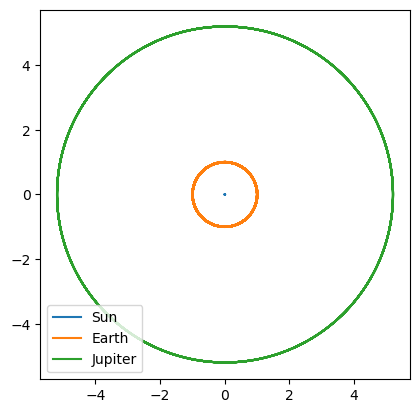

In [9]:
new_soln = odeint(deriv, new_ic, times, args=(mass,))

# Make the plot here
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(new_soln[:,0], new_soln[:,1],  label='Sun')
ax.plot(new_soln[:,6], new_soln[:,7],  label='Earth')
ax.plot(new_soln[:,12], new_soln[:,13],  label='Jupiter')
ax.legend()
ax.set_aspect('equal')

## A class to simplify the analysis

Now we want to investigate things like energy conservation. We'll build a class to store the result of the simulation, and add functions to it to calculate the total momentum, total kinetic energy, and total potential energy.

$$\mathrm{KE} = \sum\limits_{i} \frac{1}{2} m_i |\vec{v_i}|^2$$

$$\mathrm{PE} = - \sum\limits_{i<j} \frac{G m_i m_j}{r_{i,j}}$$

The gravitational constant $G$ can be replaced by `scale_factor` in the units we use in the code.

When we write the code for these, we need to sum the $|\vec{v}_i|^2$ over the three dimensions. But there is also a time dimension and we don't want to sum over that. We can do this using the `axis` option in `np.sum`. If we do `np.sum(arr, axis=-1)`, it will only sum over the last dimension of the array, and leave the time dimension alone. It's helpful to check the shapes of the inputs and outputs as you write the functions below.

### Exercise

Fill in the class below with functions for total momentum, total kinetic, and total potential energies. Look at the derivatives function for inspiration. This is difficult, so take your time and test your output.

In [10]:
# We have added some bits here for later examples as well

class NBody():
    def __init__(self, mass, times, deriv_function, initial_conditions, rtol=None, atol=None):
        self.n_obj = len(mass)
        self.mass = mass
        self.deriv = deriv_function
        self.initial_conditions = initial_conditions
        self.times = times

        self.soln = odeint(deriv_function, self.initial_conditions, times, args=(mass,), rtol=rtol, atol=atol)

    def initial_momentum(self, ic):
        p_sum = np.zeros(3)
        for i in range(self.n_obj):
            vel = ic[6 * i + 3:6 * (i + 1)]
            p_sum +=  self.mass[i] * vel
        return p_sum

    @property
    def m_total(self):
        return np.sum(mass)
    
    def pos(self, i):
        return self.soln[:, 6*i:6*i+3]

    def distance(self, i, j):
        return np.sqrt(np.sum((self.pos(i) - self.pos(j)) ** 2, axis=-1))
    
    def vel(self, i):
        return self.soln[:, 6*i+3:6*i+6]
    
    def momentum(self, i):
        return self.mass[i] * self.vel(i)
    
    def total_momentum(self):
        total_m = np.zeros(len(self.soln), 3)
        for i in range(self.n_obj):
            total_m += self.momentum(i)
        return total_m
        
    def total_kinetic(self):
        total_ke = np.zeros(len(self.times))
        for i in range(self.n_obj):
            v_i = self.vel(i)
            total_ke += 0.5 * self.mass[i] * np.sum(v_i**2, axis=1)
        return total_ke
    
    def potential(self, i, j):
        return -scale_factor * self.mass[i] * self.mass[j] / self.distance(i, j)
    
    def total_potential(self):
        total_pe = np.zeros(len(self.times))
        for i in range(self.n_obj):
            for j in range(i):
                total_pe += self.potential(i,j)
        return total_pe


### Exercise

Now load your simulation into the `NBody` class, calculate the total energy, and show that it is conserved. Is the conservation perfect? Does it oscillate?

In [11]:
nb = NBody(mass, times, deriv, new_ic)

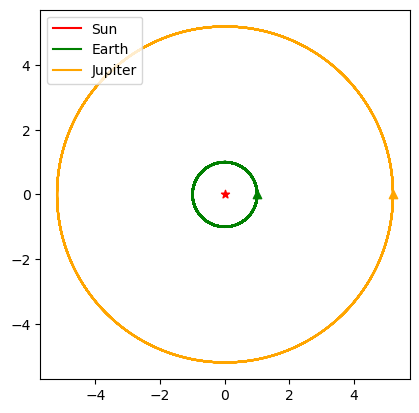

In [12]:
plt.plot(nb.pos(0)[:,0], nb.pos(0)[:,1], label='Sun', c='r')
plt.plot(nb.pos(1)[:,0], nb.pos(1)[:,1], label='Earth', c='g')
plt.plot(nb.pos(2)[:,0], nb.pos(2)[:,1], label='Jupiter', c='orange')
plt.scatter(nb.initial_conditions[0], nb.initial_conditions[1], c='r', marker='*')
plt.scatter(nb.initial_conditions[6], nb.initial_conditions[7], c='g', marker='^')
plt.scatter(nb.initial_conditions[12], nb.initial_conditions[13], c='orange', marker='^')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

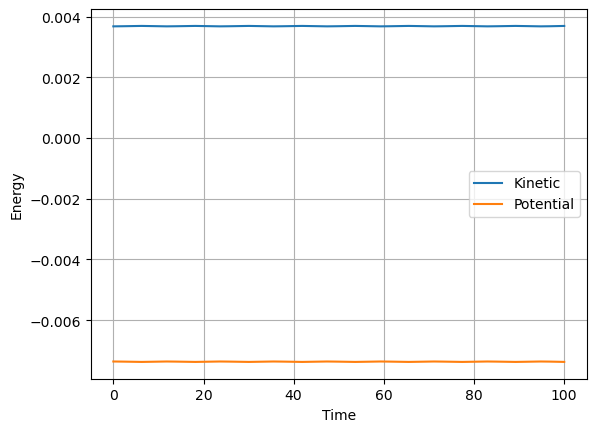

In [13]:
Ktot = nb.total_kinetic()
Vtot = nb.total_potential()

plt.plot(nb.times, Ktot, label='Kinetic')
plt.plot(nb.times, Vtot, label='Potential')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.grid()

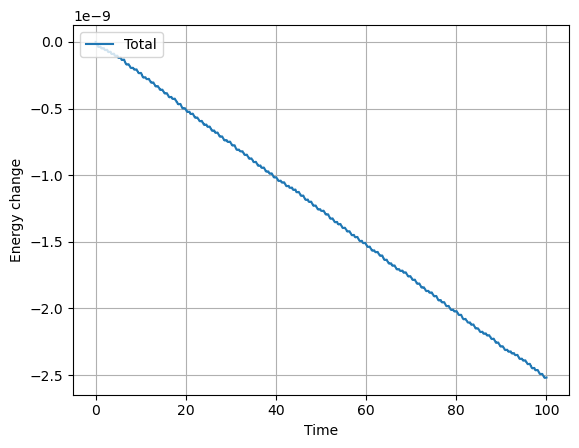

In [14]:

Etot = Ktot + Vtot


plt.plot(nb.times, Etot - Etot[0], label='Total')
plt.xlabel('Time')
plt.ylabel('Energy change')
plt.legend(loc='upper left')
plt.grid()

The conservation isn't exactly perfect, probably due to inaccuracy in the simulation. There is no oscillation

### Exercise

Now see how long you can run the simulation for. How well is the energy conserved? This is an indication of how accurate the simulation is. Numerical errors will cause the total energy to change.

In [15]:
longer_times = np.linspace(0, 1000, 100000)
nb_longer = NBody(mass, longer_times, deriv, new_ic)


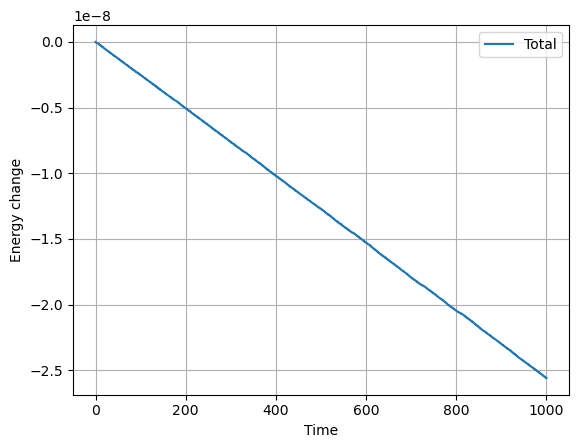

In [16]:

Ktot_longer = nb_longer.total_kinetic()
Vtot_longer = nb_longer.total_potential()
Etot_longer = Ktot_longer + Vtot_longer

plt.plot(nb_longer.times, Etot_longer - Etot_longer[0], label='Total')
plt.xlabel('Time')
plt.ylabel('Energy change')
plt.legend()
plt.grid()

### Exercise

Try decreasing the accuracy of the solver, using the options `rtol` and `atol`. Can you make the simulation run faster by decreasing these? Does using fewer output points in the `times` series make a difference? What's the longest time you can simulate while keeping reasonable accuracy of the total energy?

In [17]:
# We can use timeit to repeatedly run the same command over and over to test how long it takes.
# Commented out here so the notebook doesnt take too long

# %timeit NBody(mass, times, deriv, new_ic)
# %timeit NBody(mass, longer_times, deriv, new_ic)
# %timeit NBody(mass, longer_times, deriv, new_ic, rtol=1e-2, atol=1e-2)


In [18]:
fewer_times = np.linspace(0, 1000, 30000)
nb_less_accurate = NBody(mass, fewer_times, deriv, new_ic, rtol=1e-5, atol=1e-5)

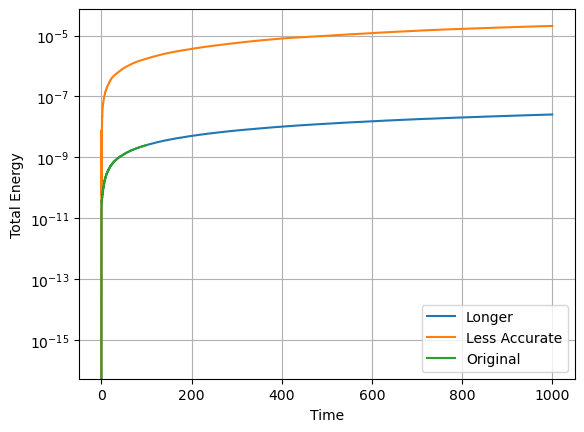

In [19]:
Ktot_less = nb_less_accurate.total_kinetic()
Vtot_less = nb_less_accurate.total_potential()
Etot_less = Ktot_less + Vtot_less

plt.semilogy(nb_longer.times, abs(Etot_longer - Etot_longer[0]), label='Longer')
plt.plot(nb_less_accurate.times, abs(Etot_less - Etot_less[0]), label='Less Accurate')
plt.plot(nb.times, abs(Etot - Etot[0]), label='Original')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.grid()

## Binary Star Systems

### Exercise

Now simulate a binary star system. Start with equal-mass stars. You'll need to change the `mass` array. It will be easy to get an elliptical orbit. You'll be able to see that it's elliptical because the kinetic and potential energies will oscillate (though the sum won't).

In [20]:
star_mass = np.array([1.5, 1.5])

star_ic = np.array([
    0.2, 0, 0, 0, 6, 0, # First star
    0, 0, 0, 0, -6, 0, # Second star
])
star_ic = remove_center_of_mass_effects(star_ic, star_mass)

star_times = np.linspace(0, 0.05, 300)
star_nb = NBody(star_mass, star_times, deriv, star_ic)

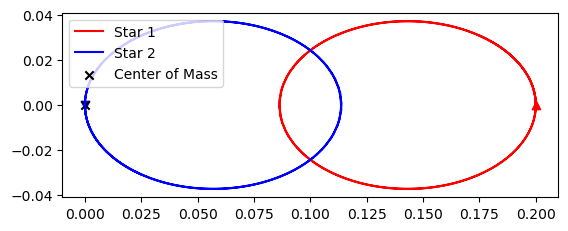

In [21]:
plt.plot(star_nb.pos(0)[:,0], star_nb.pos(0)[:,1], label='Star 1', c='r')
plt.plot(star_nb.pos(1)[:,0], star_nb.pos(1)[:,1], label='Star 2', c='b')
plt.scatter(star_nb.initial_conditions[0], star_nb.initial_conditions[1], c='r', marker='^')
plt.scatter(star_nb.initial_conditions[6], star_nb.initial_conditions[7], c='b', marker='v')
plt.scatter(0, 0, marker='x', c='k', label='Center of Mass')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

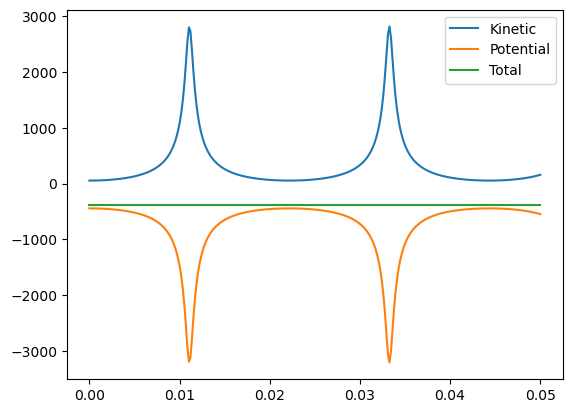

In [22]:
Ktot_star_nb = star_nb.total_kinetic()
Vtot_star_nb = star_nb.total_potential()

plt.plot(star_nb.times, Ktot_star_nb, label='Kinetic')
plt.plot(star_nb.times, Vtot_star_nb, label='Potential')
plt.plot(star_nb.times, Ktot_star_nb + Vtot_star_nb, label='Total')
plt.legend()

Text(0, 0.5, 'Total Energy change')

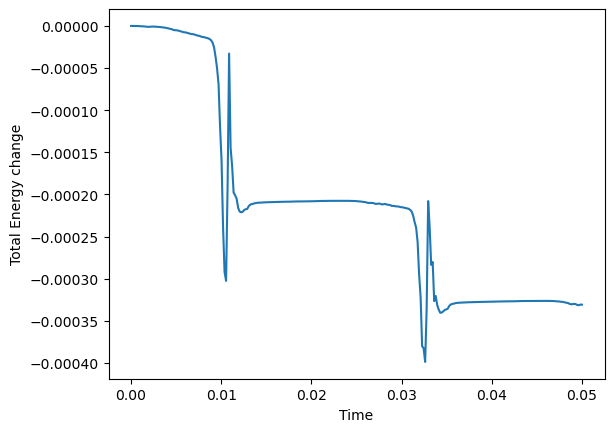

In [23]:
star_Etot = star_nb.total_kinetic() + star_nb.total_potential()
plt.plot(star_nb.times, star_Etot - star_Etot[0], label='Total')
plt.xlabel("Time")
plt.ylabel("Total Energy change")

### Exercise

Choose the initial velocities that make the orbits circular (meaning that the distance doesn't change over time, or the KE and PE don't oscillate). You can do this by numerically solving for a solution where the distance doesn't vary, or do the calculation analytically. Either way, check your solution.

In [24]:
star_mass = np.array([1.5, 1.5])

# To get circular velocities, we balance centripetal force with gravitational force
# We also need to consider the reduced mass of the system
# centripetal_acceleration = velocity**2 / dist
# gravitational_acceleration = scale_factor * reduced_mass / dist**2
# so for centripetal_force = gravitational_force,
dist = 0.1
reduced_mass = star_mass[0] * star_mass[1] / (star_mass[0] + star_mass[1])
v_balanced = np.sqrt(scale_factor * reduced_mass / (dist))

star_ic = np.array([
    dist / 2, 0, 0, 0, v_balanced, 0, # First star
    -dist / 2, 0, 0, 0, -v_balanced, 0, # Second star
])
star_ic = remove_center_of_mass_effects(star_ic, star_mass)

star_times = np.linspace(0, 0.05, 300)
star_circ = NBody(star_mass, star_times, deriv, star_ic, rtol=1e-5, atol=1e-5)

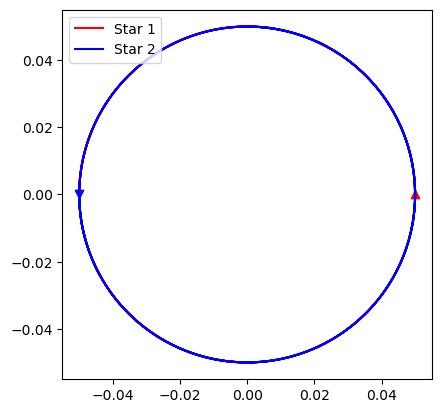

In [25]:
plt.plot(star_circ.pos(0)[:,0], star_circ.pos(0)[:,1], label='Star 1', c='r')
plt.plot(star_circ.pos(1)[:,0], star_circ.pos(1)[:,1], label='Star 2', c='b')
plt.scatter(star_circ.initial_conditions[0], star_circ.initial_conditions[1], c='r', marker='^')
plt.scatter(star_circ.initial_conditions[6], star_circ.initial_conditions[7], c='b', marker='v')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

Text(0.5, 0, 'Time')

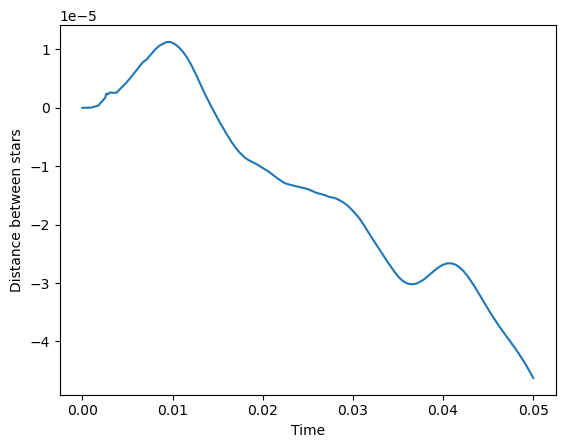

In [26]:
# This is the change of distance between the two stars
plt.plot(star_circ.times, star_circ.distance(0,1) - star_circ.distance(0,1)[0])
plt.ylabel("Distance between stars")
plt.xlabel("Time")

Text(0, 0.5, 'Energy change')

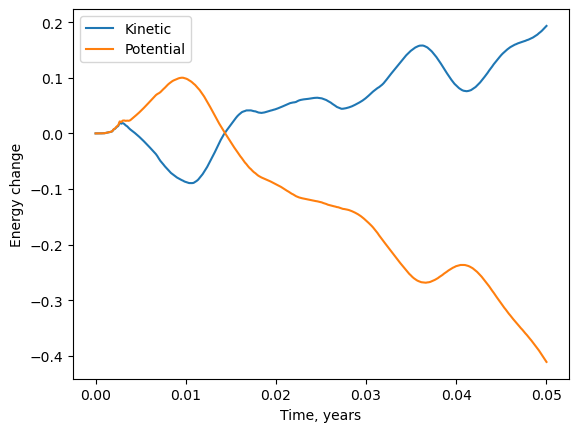

In [27]:
K_circ = star_circ.total_kinetic()
V_circ = star_circ.total_potential()
# Check that the kinetic / potential energy is constant
plt.plot(star_circ.times, K_circ - K_circ[0], label='Kinetic')
plt.plot(star_circ.times, V_circ - V_circ[0], label='Potential')
plt.legend(loc='upper left')
plt.xlabel("Time, years")
plt.ylabel("Energy change")

Text(0, 0.5, 'Change in total energy')

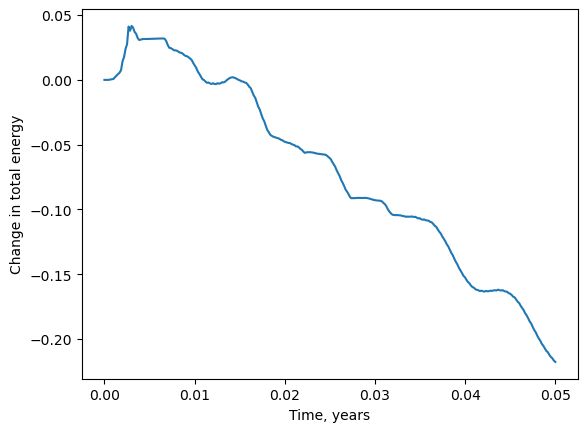

In [28]:
# Check that the total energy stays the same as well
Etot_circ = K_circ + V_circ
plt.plot(star_circ.times, Etot_circ - Etot_circ[0], label='Total')
plt.xlabel("Time, years")
plt.ylabel("Change in total energy")

### Exercise

Now create and test a binary with unequal masses. Start with a two-to-one ratio, but can you write a function to create the initial conditions for any masses, and any separation? Test that you have circular motion.

In [29]:
star_mass = np.array([1, 0.5]) # in solar masses

# To get the velocities, we balance centripetal force with gravitational force
# centripetal_acceleration = velocity**2 / dist
# gravitational_acceleration = scale_factor * reduced_mass / dist**2
# so for centripetal_force = gravitational_force,
dist = 0.4
reduced_mass = star_mass[0] * star_mass[1] / (star_mass[0] + star_mass[1])
v_balanced = np.sqrt(scale_factor * reduced_mass / dist)

star_ic = np.array([
    0, 0, 0, 0, v_balanced, 0, # First star
    -dist, 0, 0, 0, -v_balanced, 0, # Second star
])
star_ic = remove_center_of_mass_effects(star_ic, star_mass)

star_times = np.linspace(0, 0.5, 1000)
star_uneq = NBody(star_mass, star_times, deriv, star_ic)

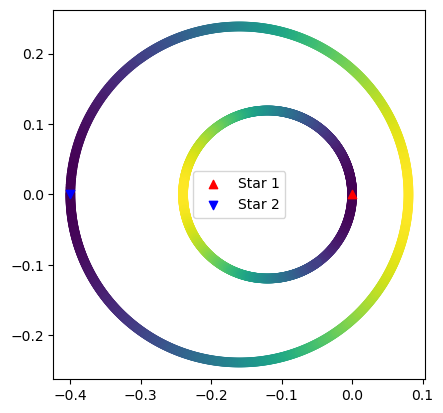

In [30]:
plt.scatter(star_uneq.pos(0)[:,0], star_uneq.pos(0)[:,1], c=np.sqrt(np.sum(star_uneq.vel(0) ** 2, axis=1)))
plt.scatter(star_uneq.pos(1)[:,0], star_uneq.pos(1)[:,1], c=np.sqrt(np.sum(star_uneq.vel(1) ** 2, axis=1)))
plt.scatter(star_uneq.initial_conditions[0], star_uneq.initial_conditions[1], c='r', marker='^', label='Star 1')
plt.scatter(star_uneq.initial_conditions[6], star_uneq.initial_conditions[7], c='b', marker='v', label='Star 2')
plt.legend()
plt.gca().set_aspect('equal')

Text(0, 0.5, 'Energy')

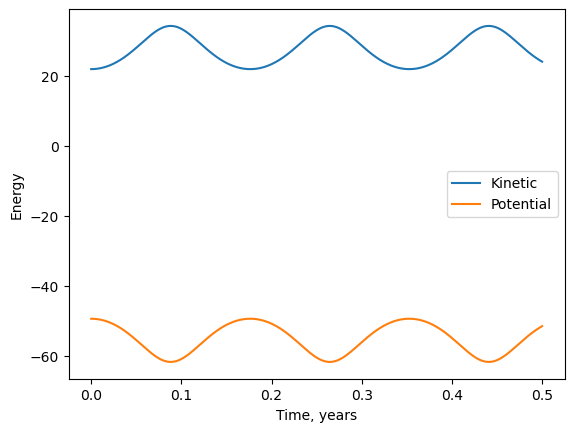

In [31]:
K_uneq = star_uneq.total_kinetic()
V_uneq = star_uneq.total_potential()
Etot_uneq = K_uneq  + V_uneq

plt.plot(star_uneq.times, K_uneq, label='Kinetic')
plt.plot(star_uneq.times, V_uneq, label='Potential')
plt.legend()
plt.xlabel("Time, years")
plt.ylabel("Energy")

Text(0, 0.5, 'Energy change')

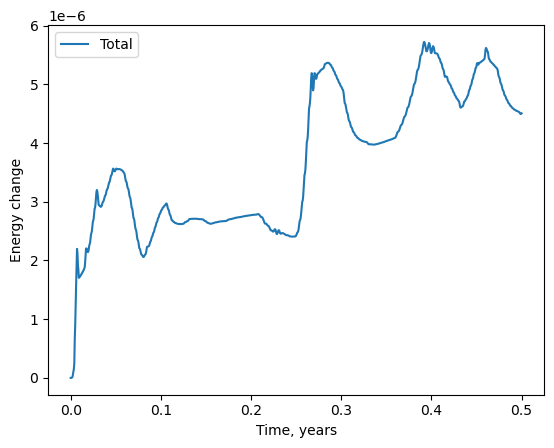

In [32]:
plt.plot(star_uneq.times, Etot_uneq - Etot_uneq[0], label='Total')
plt.legend()
plt.xlabel("Time, years")
plt.ylabel("Energy change")

As the stars are travelling at a varying velocity, the kinetic and potential energy will be oscillating
This is despite the fact that they are travelling in circular orbits.
To prove that they are travelling in circular orbits, we use the following plot:

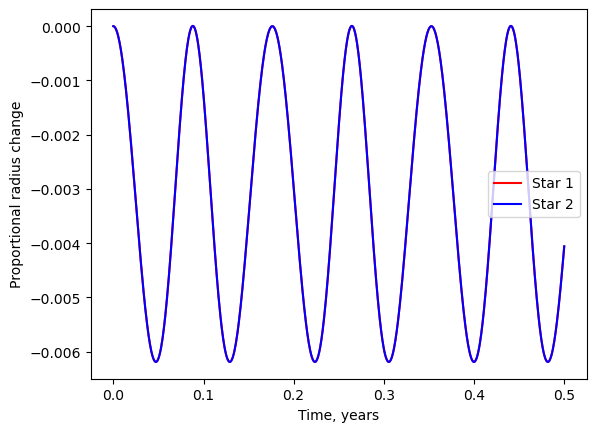

In [33]:

# The centre of the circle will be on the x-axis, and is the mean of the max and min values in the x-direction
centre_0 = np.array([(star_uneq.pos(0)[:,0].max() + star_uneq.pos(0)[:,0].min()) / 2, 0, 0])
centre_1 = np.array([(star_uneq.pos(1)[:,0].max() + star_uneq.pos(1)[:,0].min()) / 2, 0, 0])
# Distance from the centre of its own orbit
r0 = np.sqrt(np.sum((star_uneq.pos(0) - centre_0) ** 2, axis=1))
r1 = np.sqrt(np.sum((star_uneq.pos(1) - centre_1) ** 2, axis=1))
# Plot the difference between this and the start radius
plt.plot(star_uneq.times, (r0 - r0[0]) / r0[0], c='r', label="Star 1")
plt.plot(star_uneq.times, (r1 - r1[0]) / r1[0], c='b', label="Star 2")
plt.xlabel("Time, years")
plt.ylabel("Proportional radius change")
plt.legend()

This shows that we are circular to within ~0.5%. So we are happy to say this is circular

### Exercise

Now try replacing the Sun with two stars of $0.5 M_\odot$, in an orbit much smaller than 1 AU. Is the solar system still stable?

In [34]:
ss_mass = np.array([0.5, 0.5, mE, mJ])

dist = 0.1
reduced_mass = ss_mass[0] * ss_mass[1] / (ss_mass[0] + ss_mass[1])
v_balanced = np.sqrt(scale_factor * reduced_mass / (dist))

ss_ic = np.array([
    dist / 2, 0, 0, 0, v_balanced, 0, # First star
    -dist / 2, 0, 0, 0, -v_balanced, 0, # Second star
    rE, 0, 0, 0, np.sqrt(scale_factor/rE), 0, # xEx, xEy, xEz, vEx, vEy, vEz
    rJ, 0, 0, 0, np.sqrt(scale_factor/rJ), 0, # xJx, xJy, xJz, vJx, vJy, vJz
    
])

# simulate for 15 years so that we get a full Jupiter orbit
# We need to get enough data points so that the orbits of the stars can still be modelled though!
ss_times = np.linspace(0, 13, 100000)
ss_nb = NBody(ss_mass, ss_times, deriv, ss_ic)

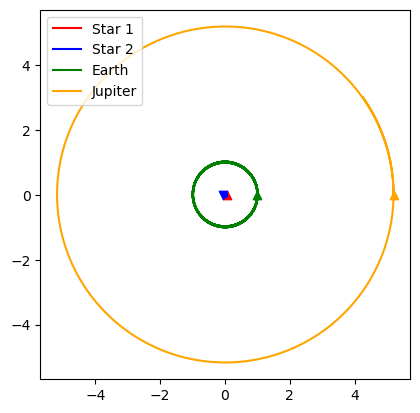

In [35]:
plt.plot(ss_nb.pos(0)[:,0], ss_nb.pos(0)[:,1], label='Star 1', c='r')
plt.plot(ss_nb.pos(1)[:,0], ss_nb.pos(1)[:,1], label='Star 2', c='b')
plt.plot(ss_nb.pos(2)[:,0], ss_nb.pos(2)[:,1], label='Earth', c='g')
plt.plot(ss_nb.pos(3)[:,0], ss_nb.pos(3)[:,1], label='Jupiter', c='orange')
plt.scatter(ss_ic[0], ss_ic[1], c='r', marker='^')
plt.scatter(ss_ic[6], ss_ic[7], c='b', marker='v')
plt.scatter(ss_ic[12], ss_ic[13], c='g', marker='^')
plt.scatter(ss_ic[18], ss_ic[19], c='orange', marker='^')
plt.legend(loc='upper left')
# This will make the plot look a bit weird, but it means we can see that the stars are actually moving!
# plt.gca().set_xscale('symlog', linthresh=0.015)
# plt.gca().set_yscale('symlog', linthresh=0.015)
plt.gca().set_aspect('equal')

Text(0, 0.5, 'Energy')

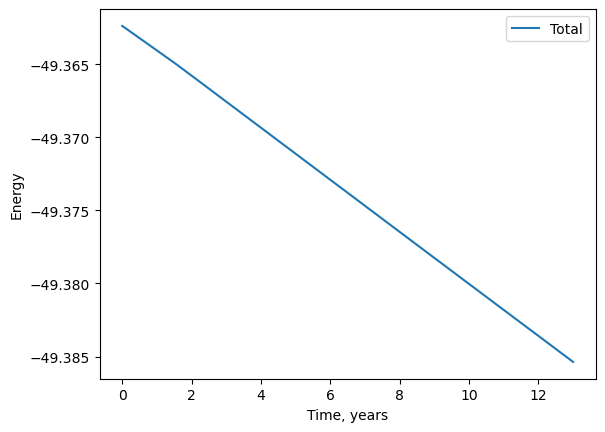

In [36]:
# plt.plot(ss_nb.times, ss_nb.total_kinetic(), label='Kinetic')
# plt.plot(ss_nb.times, ss_nb.total_potential(), label='Potential')
plt.plot(ss_nb.times, ss_nb.total_kinetic() + ss_nb.total_potential(), label='Total')
plt.legend()
plt.xlabel("Time, years")
plt.ylabel("Energy")

The solar system is stable

### Exercise

If you have extra time, try experimenting with trinary systems. Put two stars at the center, and one orbiting them both at a larger distance. What kind of solutions can you get?

We will not provide a solution to this exercise
